In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, InputLayer

In [2]:
# Load dataset
df = pd.read_csv('dataset/laptop_cleaned2.csv')

# Pilih kolom harga penutupan
data = df['Price'].values.reshape(-1, 1)

# Normalisasi data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Buat dataset untuk pelatihan
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Buat dataset dengan jendela waktu
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input menjadi [samples, time steps, features] yang dibutuhkan LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [3]:
# Membuat model LSTM
model = Sequential()
model.add(InputLayer(shape=(time_step, 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Kompilasi model
model.compile(optimizer='adam', loss='mean_squared_error')

# Latih model
model.fit(X_train, y_train, batch_size=1, epochs=1)

715/715 ━━━━━━━━━━━━━━━━━━━━ 72s 82ms/step - loss: 0.0130


In [4]:
# Prediksi
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invers transformasi untuk mendapatkan nilai asli
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

# Hitung RMSE (Root Mean Squared Error)
import math
from sklearn.metrics import mean_squared_error
train_rmse = math.sqrt(mean_squared_error(y_train[0], train_predict[:,0]))
test_rmse = math.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')


23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Train RMSE: 60938.53576213713
Test RMSE: 60353.86198285848


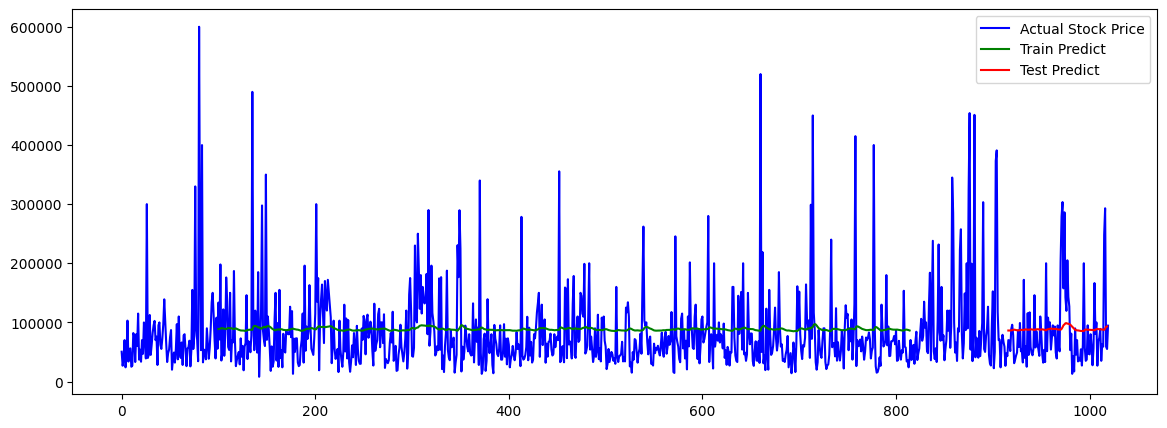

In [5]:
# Plot data prediksi dan aktual
plt.figure(figsize=(14,5))
plt.plot(df['Price'], color='blue', label='Actual Stock Price')

# Pastikan array dengan dtype float
train_predict_plot = np.empty_like(data, dtype=float)
train_predict_plot[:, :] = np.nan
train_predict_plot[time_step:len(train_predict)+time_step, :] = train_predict

test_predict_plot = np.empty_like(data, dtype=float)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(time_step*2)+1:len(data)-1, :] = test_predict

plt.plot(train_predict_plot, color='green', label='Train Predict')
plt.plot(test_predict_plot, color='red', label='Test Predict')
plt.legend()
plt.show()

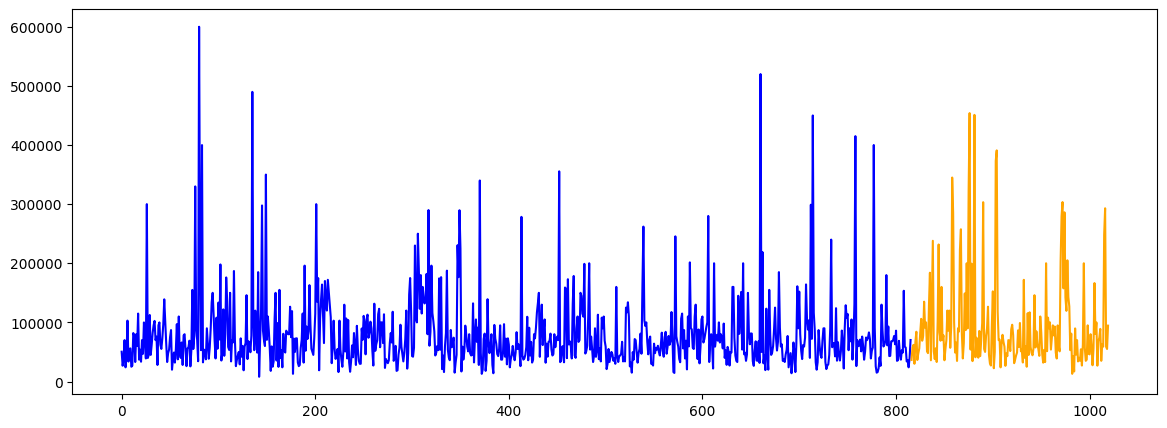

In [6]:
# Plot data prediksi dan aktual
plt.figure(figsize=(14,5))
plt.plot(df.index[:train_size], scaler.inverse_transform(train_data), color='blue', label='Actual Train Data')
plt.plot(df.index[train_size:], scaler.inverse_transform(test_data), color='orange', label='Actual Test Data')

# Penyesuaian dimensi untuk plot prediksi
train_predict_plot = np.empty_like(data, dtype=float)
train_predict_plot[:, :] = np.nan
train_predict_plot[time_step:len(train_predict)+time_step, 0] = train_predict[:, 0]

test_predict_plot = np.empty_like(data, dtype=float)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(time_step*2)+1:len(data)-1, 0] = test_predict[:, 0]

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Menghitung RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))

# Menghitung MAE (Mean Absolute Error)
mae = mean_absolute_error(y_test[0], test_predict[:,0])

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')


RMSE: 60353.86198285848
MAE: 43949.216777912625


In [9]:
# Menyimpan model
model.save('model_lstm_LaptopLens.h5')

# Memuat model
from tensorflow.keras.models import load_model
model = load_model('model_lstm_LaptopLens.h5')

# Melakukan prediksi dengan model yang telah dimuat
recent_data = test_data[-time_step:].reshape(1, time_step, 1)
future_price = model.predict(recent_data)
future_price = scaler.inverse_transform(future_price)
print(f'Prediksi harga masa depan: {future_price}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Prediksi harga masa depan: [[91937.22]]
